In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating environment at `C:\Users\tge13\Documents\optimal_control_julia\lec_10\Project.toml`


In [2]:
using LinearAlgebra
using Plots
using ForwardDiff
using RobotZoo
using RobotDynamics
# using MatrixCalculus

In [3]:
#Acrobot Dynamics
a = RobotZoo.Acrobot()
h = 0.05

0.05

In [4]:
function dynamics_rk4(x,u)
    f1 = RobotDynamics.dynamics(a, x, u)
    f2 = RobotDynamics.dynamics(a, x + 0.5*h*f1, u)
    f3 = RobotDynamics.dynamics(a, x + 0.5*h*f2, u)
    f4 = RobotDynamics.dynamics(a, x + h*f3, u)

    return x + (h/6)*(f1 + 2*f2 + 2*f3 + f4)
end

dynamics_rk4 (generic function with 1 method)

In [5]:
function dfdx(x,u)
    return ForwardDiff.jacobian(_x -> dynamics_rk4(_x, u), x)
end

function dfdu(x, u)
    return ForwardDiff.derivative(_u -> dynamics_rk4(x, _u), u)
end

dfdu (generic function with 1 method)

In [6]:
Nx = 4     # number of state
Nu = 1     # number of controls
Tfinal = 10.0 # final time
Nt = Int(Tfinal/h)+1    # number of time steps
thist = Array(range(0,h*(Nt-1), step=h));

In [7]:
# Cost weights
Q = Diagonal([1.0, 1.0, 0.1, 0.1])
R = 0.01
Qn = Array(100.0*I(Nx))

4×4 Matrix{Float64}:
 100.0    0.0    0.0    0.0
   0.0  100.0    0.0    0.0
   0.0    0.0  100.0    0.0
   0.0    0.0    0.0  100.0

In [8]:
function cost(xtraj,utraj)
    J = 0
    for k in 1:(Nt-1)
        J = J + 0.5*(xtraj[:,k] - xgoal)'*Q*(xtraj[:,k] - xgoal) + 0.5*R*utraj[k]*utraj[k]
    end
    J = J + 0.5*(xtraj[:,end] - xgoal)'*Qn*(xtraj[:,end] - xgoal)
end

cost (generic function with 1 method)

In [21]:
#Initial guess
x0 = [-pi/2; 0; 0; 0]
xgoal = [pi/2; 0; 0; 0]
xtraj = kron(ones(1,Nt), x0)
utraj = randn(Nt-1);

In [22]:
#Initial Rollout
for k in 1:(Nt-2)
    xtraj[:,k+1] .= dynamics_rk4(xtraj[:,k], utraj[k])
end
J = cost(xtraj,utraj)

1480.4139298379268

## DDP Algorithm

In [23]:
d = ones(Nt-1)
iter = 0
xn = zeros(size(xtraj))
un = zeros(size(utraj))

while maximum(abs.(d[:])) > 1e-3
    p = zeros(Nx, Nt)
    P = zeros(Nx, Nx, Nt)
    d = ones(Nt-1)
    K = zeros(Nu,Nx,Nt-1)
    
    ΔJ = 0.0
    p[:,end] = Qn*(xtraj[:,end]-xgoal)
    P[:,:,end] = Qn
    
    for k = (Nt-1):-1:1
        ∇ₓl = Q * (xtraj[:,k] - xgoal)
        ∇ᵤl = R * (utraj[k])
        
        A = dfdx(xtraj[:,k], utraj[k])
        B = dfdu(xtraj[:,k], utraj[k])
    
        gₓ = ∇ₓl + A'*p[:,k+1]
        gᵤ = ∇ᵤl + B'*p[:,k+1]
    
        Gxx = Q + A'*P[:,:,k+1]*A
        Guu = R + B'*P[:,:,k+1]*B
        Gxu = A'*P[:,:,k+1]*B
        Gux = B'*P[:,:,k+1]*A
    
        d[k] = Guu\gᵤ
        K[:,:,k] .= Guu\Gux
    
        P[:,:,k] .= Gxx + K[:,:,k]'*Guu*K[:,:,k] - Gxu*K[:,:,k] - K[:,:,k]'*Gux
        p[:,k] .= dropdims(gₓ - K[:,:,k]'*gᵤ + K[:,:,k]'*Guu*d[k] - Gxu*d[k], dims=2)
    
        ΔJ += gᵤ'*d[k]
    end
    
    # Line Search
    xn[:,1] = x0
    α = 1.0
    
    for k in 1:(Nt-1)
        un[k] = utraj[k] - α*d[k] - dot(K[:,:,k], (xn[:,k] - xtraj[:,k]))
        xn[:,k+1] .= dynamics_rk4(xn[:,k], un[k])
    end
    Jn = cost(xn,un)
    
    while isnan(Jn) || Jn > (J - 1e-2*α*ΔJ)
        α *= 0.5
        for k in 1:(Nt-1)
            un[k] = utraj[k] - α*d[k] - dot(K[:,:,k], (xn[:,k] - xtraj[:,k]))
            xn[:,k+1] .= dynamics_rk4(xn[:,k], un[k])
        end
        Jn = cost(xn,un)
    end

    iter += 1
    J = Jn
    xtraj .= xn
    utraj .= un
end

In [24]:
iter, J

(328, 562.122887917825)

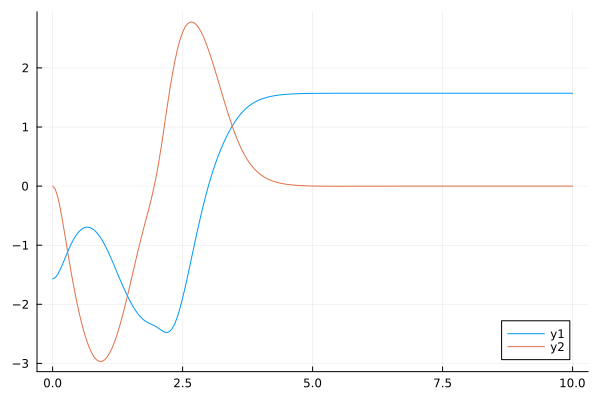

In [14]:
plot(thist,xtraj[1,:])
plot!(thist,xtraj[2,:])

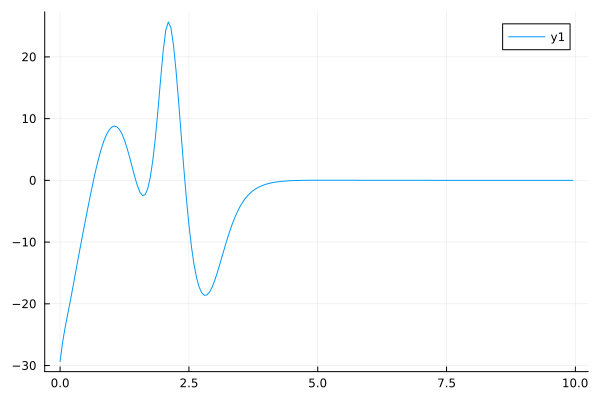

In [15]:
plot(thist[1:Nt-1],utraj)

In [16]:
using TrajOptPlots
using MeshCat
using StaticArrays

vis = Visualizer()
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8700


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), Set{Any}(), ip"127.0.0.1", 8700))

In [17]:
TrajOptPlots.set_mesh!(vis, a)

MeshCat Visualizer with path /meshcat/robot/link1/joint at http://127.0.0.1:8700

In [18]:
X1 = [SVector{4}(x) for x in eachcol(xtraj)];
visualize!(vis, a, thist[end], X1)